In [1]:
from langchain.tools import tool
import yfinance as yf
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"
     
    

In [2]:
get_stock_price.invoke("AAPL")

'The last closing price of AAPL was $258.02.'

In [4]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b

In [5]:
tools = [add, multiply, divide,get_stock_price]

In [6]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0
)


d:\Chetan Pande\AI-ML-2025\agentic-ai-2.0\langgraph_llm_tools\tools-venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
llm_with_tools=llm.bind_tools(tools)

In [8]:
response=llm_with_tools.invoke("can you give me a latest stock price of adani greens?")
response.content

''

In [9]:
response.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'ADANIGREEN.NS'},
  'id': 'nq10dx9s5',
  'type': 'tool_call'}]

In [11]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START
SYSTEM_PROMPT = SystemMessage(
    content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs."
)
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

In [12]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)
workflow.add_node("llm_decision_step", function_1)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "llm_decision_step")
workflow.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
workflow.add_edge("tools", "llm_decision_step")
react_graph2 = workflow.compile()

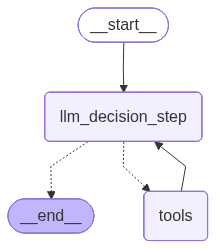

In [14]:
from IPython.display import Image, display
display(Image(react_graph2.get_graph(xray=True).draw_mermaid_png()))

In [16]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
messages = react_graph2.invoke({"messages": messages})

In [17]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (srwx0kh6m)
 Call ID: srwx0kh6m
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $258.02.
================================== Ai Message ==================================

The result of adding 1000 to the current stock price of Apple (AAPL) is:

**1258.02**
